# Developing an Image Classifier using Deep Learning

In this project, I trained an image classifier to recognise different species of flowers. I used [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. Data can be downloaded [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).


This project can be easily genaralised to train on another labelled photo dataset.

In this notebook I demonstrate the trained model. The training code can be seen in the .py files in the repository [here](https://github.com/rd98/flower-classifier) and is implemented via a command line application.

<img src='inference_example.png' width=300px>

Firstly, import the necessary packages. I predominantly used Pytorch in this project.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models

import json

from PIL import Image


## Loading and Preprocessing of the data

Here I used `torchvision` to load the data. The dataset is split into three parts, training, validation, and testing. For the training, I applied transformations such as random scaling, cropping, and flipping. This helped the network generalise leading to better performance on unseen data.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this  scaling or rotation transformations were not needed, but I still needed to resize and crop the images to the appropriate size.

In this project I utilised transfer learning to optimise training. This meant loading in deep neural network which had already been trained to identify features in images. Once this was loaded I just needed to add on a few hidden layers to the end to act as a classifier for the particular application in question.

The pre-trained networks I used were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I had to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1. Also, the pretrained networks take images of size 224x224 and so inputs must be resized as required.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalise])
test_transforms = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalise])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalise])
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)


# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64,shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64,shuffle=True)

### Label mapping

I also needed to load in a mapping from category label to category name. The category-name relationships were given via a .json file and thus had to be read in with the [`json` module](https://docs.python.org/2/library/json.html). This gives a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name_temp = sorted(cat_to_name)

# Building and training the classifier

The steps I took to build the model were as follows:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) from `torchvision.models` (In this case I have used densenet121)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers via backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

Note : When training it is important to freeze the parameters of the pretrained network to ensure that it is not being re-trained which would be computationally very taxing. In other words, the training process should only be back propagating through the classifier.

In this notebook I have loaded a model I previously trained. Code for training can be seen in the .py files.

In [5]:
"""
Define the Network class which will be used to create the classifier

"""

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# Function which allows the model to give feedback every 
# specified number of epochs
def validation(model, testloader, criterion):
    device='cpu'
    model.to(device)
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        #images.resize_(images.shape[0], 150528)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy



## Loading the checkpoint

A function that can load a checkpoint and rebuild the model. This allows reusing without having to retrain the network.

In [7]:
def load_from_checkpoint(checkpoint_path):
    model = models.densenet121(pretrained = True)
    # Replace the pre-trained classifier with a new feed forward network
    # of the same size as the one saved in the checkpoint to be used as the classifier
    classifier = Network(1024, 102, [516, 256], drop_p=0.5)
    model.classifier = classifier
    
    state_dict = torch.load(checkpoint_path,map_location='cpu')
    
    model.load_state_dict(state_dict)
    
    return model

model = load_from_checkpoint('checkpoint.pth')

/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


## Testing the network

Test the classifier on unseen images.

In [10]:
criterion = nn.NLLLoss()

model.eval()
with torch.no_grad():
    test_loss, accuracy = validation(model,testloader,criterion)
    print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    

Test Loss: 0.935..  Test Accuracy: 0.734


# Inference for classification

The end goal is a function that takes in an image and produces the top-$K$ classes predicted by the model. Output will look something like below.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First I needed to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

I used `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). I then wrote a function that preprocesses the image so it can be used as input for the model. This function processes the images in the same manner used for training. 

First, I resized the images so that the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I croped out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1 and so I had to convert the values. It's easiest with a Numpy array, which I got from a PIL image like so `np_image = np.array(pil_image)`.

As before, the pretrained network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I subtracted the means from each color channel, then divided by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I re-ordered dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [8]:

def process_image(img):
    """
    1. Get the size of the image
    2. Get the width to height ratio in order to find what the max side length should be to maintain aspect and have
        minimum side of 256 pixels
    3. Find the cropping points to crop out the 224x224 centre portion of image
    4. Crop the image using the max value of the newly found with and height
        - this is because .thumbnail uses only the largest value and maintains the aspect based on that
    5. Crop the image based on calculated values
    6. Convert image to numpy array then normalise and transpose
        - Transpose in order to make the colour values in the correct dimension
    7. Convert to pytorch tensor and return this
    
    """
    img = Image.open(img)

    size = img.size
    width = size[0]
    height = size[1]
    ratio = width / height
    if height>width:
        new_width = 256
        new_height = 256 * (1 / ratio)
    elif height<width:
        new_width = 256 * ratio
        new_height = 256
    elif height==width:
        new_width = 256
        new_height = 256
        
    
    left = round((new_width - 224)/2)
    top = round((new_height - 224)/2)
    right = round((new_width + 224)/2)
    bottom = round((new_height + 224)/2)
    
    
    img.thumbnail((max(new_width,new_height),max(new_width,new_height)))

    img = img.crop((left,top,right,bottom))
    np_image = np.array(img)
    
    np_image = np_image / 255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean)/std
    np_image = np_image.transpose((2, 0, 1))

    
    return torch.from_numpy(np_image).float().unsqueeze(0)

The `imshow()` function below reverses the pre-processing and displays the original image.

In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Now that images are in the correct format, I wrote a function for making predictions with your model. A common practice is to display the top 5 most probable classes. This function has the ability to diplay any number the user desires however.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [10]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    device = 'cpu'
    model.to(device)
    image = image_path.to(device)
    
    model.eval()
    output = model.forward(image)
    ps = torch.exp(output)
    
    results = torch.topk(ps, topk)
    
    prob_values = []
    for i in range(len(results[0][0])):
        prob_values.append(float(torch.topk(ps,topk)[0][0][i].detach().numpy()))

    class_values = []
    for i in range(len(results[1][0])):
        class_values.append(float(torch.topk(ps,topk)[1][0][i].detach().numpy()))

    classes=[]
    for i in class_values:
        classes.append(cat_to_name[str(cat_to_name_temp[int(i)])])

    return prob_values, class_values, classes


# Test process_image and predict functions

In [11]:
"""
For testing these functions we will use one of the .jpg images from the provided data
"""
testing_image = 'flowers/test/1/image_06743.jpg'
probability, class_values, classes = predict(process_image(testing_image), model, 8)
print("Class Probabilities : {}".format(probability))
print("-----------------------")
print("Class Values : {}".format(class_values))
print("-----------------------")
print("Classes : {}".format(classes))

Class Probabilities : [0.7227017283439636, 0.06464605778455734, 0.05165275186300278, 0.029000617563724518, 0.028904061764478683, 0.02014443650841713, 0.01938880980014801, 0.013799893669784069]
-----------------------
Class Values : [0.0, 13.0, 49.0, 76.0, 84.0, 75.0, 14.0, 87.0]
-----------------------
Classes : ['pink primrose', 'balloon flower', 'petunia', 'morning glory', 'hibiscus', 'thorn apple', 'hard-leaved pocket orchid', 'tree mallow']


## Sanity Checking

To sanity check, I wrote a function that will display the top-k classes along with the picture in question so that it can be seen if predictions are correct. Output looks something like below :

<img src='inference_example.png' width=300px>


In [16]:
def predict_with_chart(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    device = 'cpu'
    model.to(device)
    image = image_path.to(device)
    
    model.eval()
    output = model.forward(image)
    ps = torch.exp(output)
    
    results = torch.topk(ps, topk)
    
    prob_values = []
    for i in range(len(results[0][0])):
        prob_values.append(float(torch.topk(ps,topk)[0][0][i].detach().numpy()))

    class_values = []
    for i in range(len(results[1][0])):
        class_values.append(float(torch.topk(ps,topk)[1][0][i].detach().numpy()))


    classes=[]
    for i in class_values:
        classes.append(cat_to_name[str(cat_to_name_temp[int(i)])])


    plt.barh(classes, prob_values)
    plt.title('Top {} Class Probabilities'.format(topk))
    for j in image:
        imshow(j)

### Testing the classifier on some images from Google

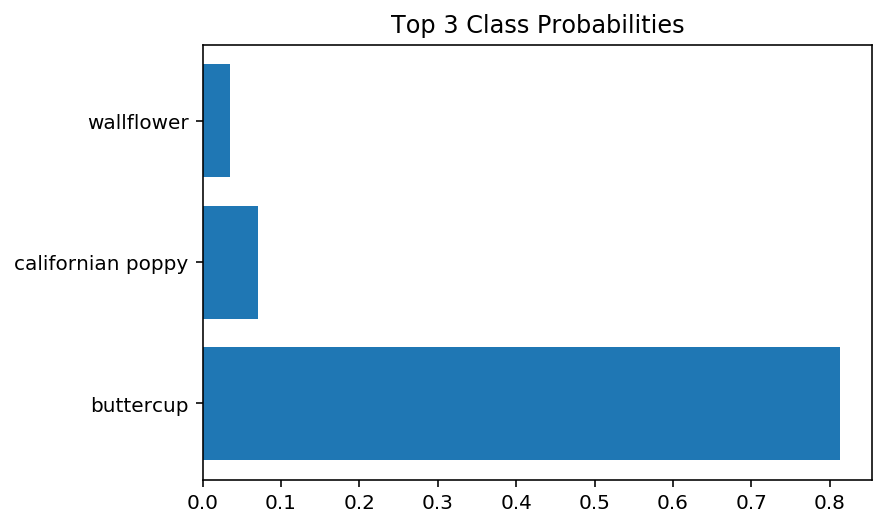

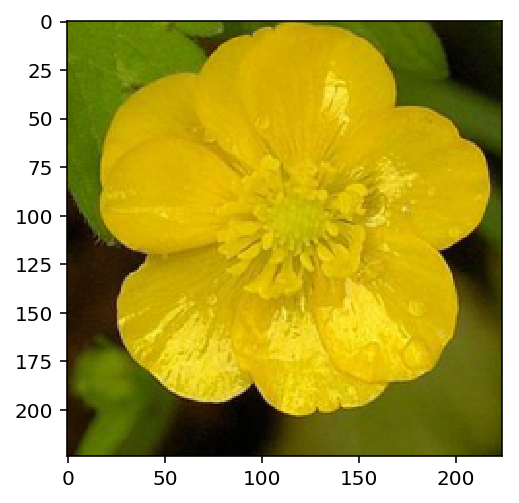

In [17]:
testing_image = 'buttercup.jpg'
predict_with_chart(process_image(testing_image), model, topk=3)

A dandelion looks very similar to a colts foot and this is reflected in the top 5 predictions below.

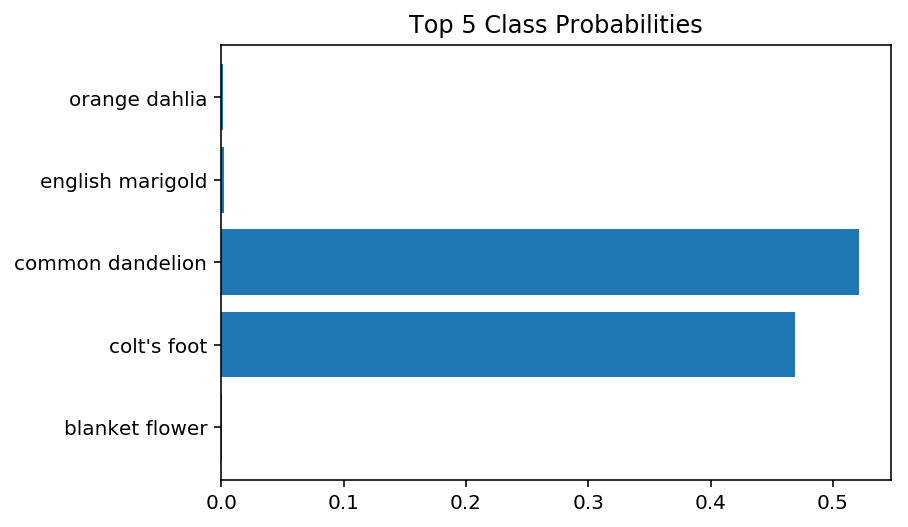

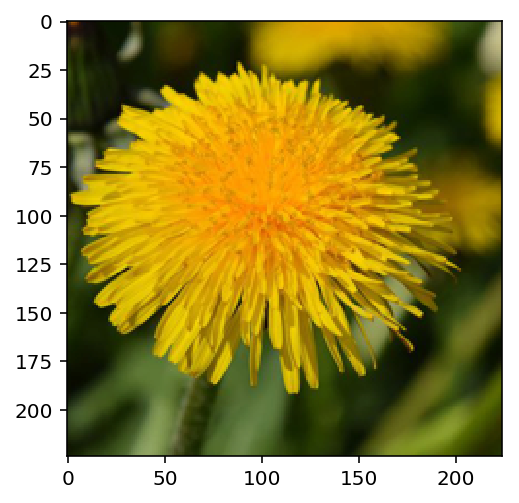

In [18]:
testing_image = 'dandelion.jpg'
predict_with_chart(process_image(testing_image), model)

The Bird of Paradise flower is a very unique flower and we can see below that this results in a clear prediction.

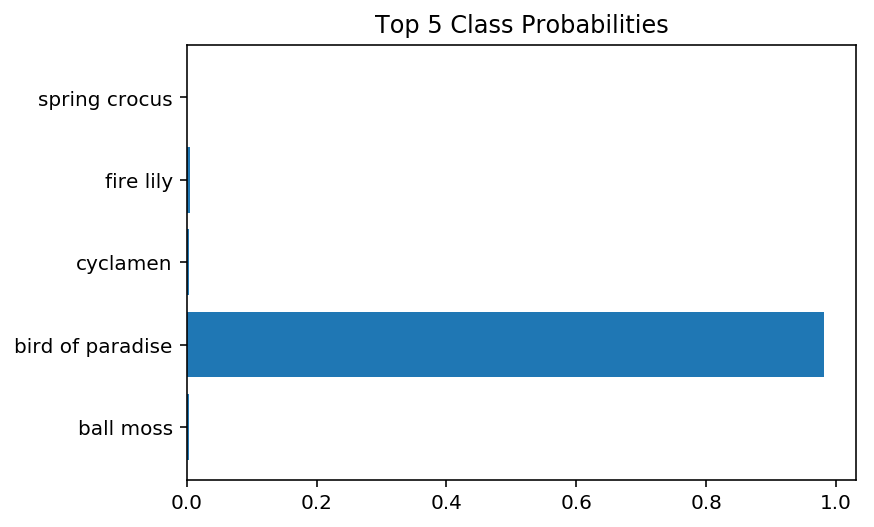

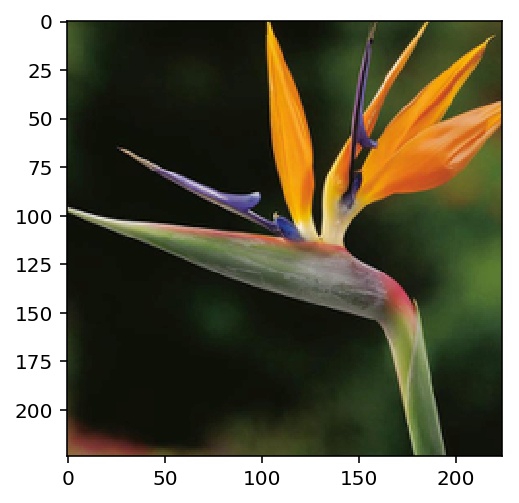

In [19]:
testing_image = 'paradise.jpg'
predict_with_chart(process_image(testing_image), model)